# Imports

## Libraries and Packages

In [3]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn-Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from skimage.metrics import structural_similarity

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# File Operations
from shutil import copy
import os

# Others
import random

## Path

Kaggle: [Handwritten Signatures](https://www.kaggle.com/divyanshrai/handwritten-signatures)

In [23]:
PATH = "../Data/Dataset_Signature_Final/"

## Setup

In [24]:
# For replicability
np.random.seed(42)

# Functions

## Loading the data into a dataframe format

In [25]:
def load_data(DATA_DIR=PATH, test_size=0.2, verbose=True, load_grayscale=True):
    """
    Loads the data into a dataframe.

    DATA_DIR: str
    test_size: float

    Returns:
        (x_train, y_train,x_test, y_test, x_val, y_val, df)
    """
    features = []
    features_forged = []
    features_real = []
    features_dict = {}
    labels = [] # forged: 0 and real: 1
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    
    for folder in os.listdir(DATA_DIR):
        # forged images
        if folder == '.DS_Store' or folder == '.ipynb_checkpoints': # Ignore non-image data/folder
            continue
    
        print ("Searching folder {}".format(folder)) # print state
        
        for sub in os.listdir(DATA_DIR+"/"+folder+"/forge"):
            f = DATA_DIR+"/"+folder+"/forge/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 0)
            features_forged.append(img)
            if verbose:
                print ("Adding {} with label 0".format(f))
            labels.append(0) # forged
        
        # real images
        for sub in os.listdir(DATA_DIR+"/"+folder+"/real"):
            f = DATA_DIR+"/"+folder+"/real/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 1)
            features_real.append(img)
            if verbose:
                print ("Adding {} with label 1".format(f))
            labels.append(1) # real
            
    features = np.array(features)
    labels = np.array(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    
    print ("Generated data.")
    return features, labels,features_forged, features_real,features_dict,X_train, X_test, y_train, y_test, X_val, y_val

## Label to Text

In [85]:
def get_category(label=0):
    """
        Convert label into text
        
        Arguments:
            label: int
        Returns:
            str: The mapping
    """
    label_category = {0: "Forged", 1: "Real"}
    return label_category[label]

# Loading the data (None gray-scaled version)

In [70]:
features, labels, features_forged, features_real, features_dict,X_train, X_test, y_train, y_test, X_val, y_val = \
load_data(verbose=False, load_grayscale=False)

Searching folder dataset1
Searching folder dataset2
Searching folder dataset3
Searching folder dataset4
Generated data.


- features = 150x150x3 (heightxwidthxrgb)
- labels = {0: Forged, 1: Real}
- features_dict = Filename: Image, label

In [57]:
len(features_forged)

360

In [58]:
len(features_real)

360

## Checking sample signatures
- imshow = display the signature
- text = category of the signature {0: Forged, 1: Real}

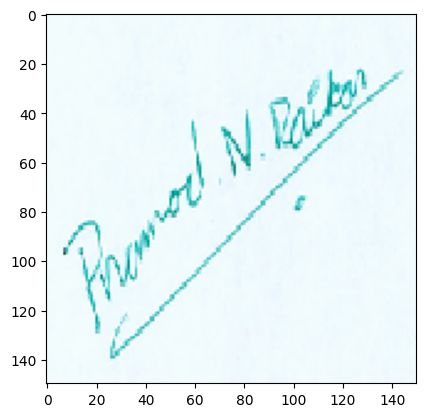

In [49]:
plt.imshow(features[1]/255.)

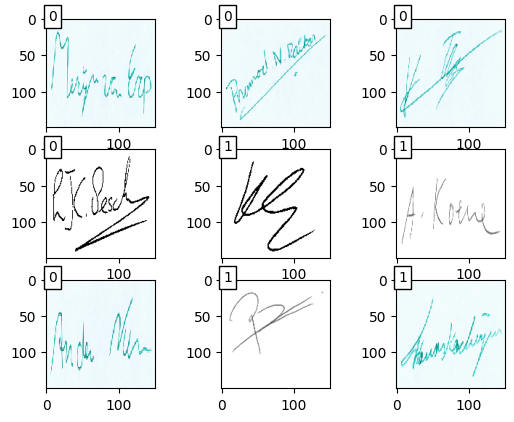

In [47]:
fig, ax = plt.subplots(3,3)

ax[0,0].imshow(features[0]/255.)
ax[0,0].text(2, 2, labels[0], bbox={'facecolor': 'white', 'pad': 3})

ax[0,1].imshow(features[1]/255.)
ax[0,1].text(2, 2, labels[1], bbox={'facecolor': 'white', 'pad': 3})

ax[0,2].imshow(features[2]/255.)
ax[0,2].text(2, 2, labels[2], bbox={'facecolor': 'white', 'pad': 3})

ax[1,0].imshow(features[300]/255.)
ax[1,0].text(2, 2, labels[300], bbox={'facecolor': 'white', 'pad': 3})

ax[1,1].imshow(features[400]/255.)
ax[1,1].text(2, 2, labels[400], bbox={'facecolor': 'white', 'pad': 3})

ax[1,2].imshow(features[512]/255.)
ax[1,2].text(2, 2, labels[512], bbox={'facecolor': 'white', 'pad': 3})

ax[2,0].imshow(features[6]/255.)
ax[2,0].text(2, 2, labels[6], bbox={'facecolor': 'white', 'pad': 3})

ax[2,1].imshow(features[200]/255.)
ax[2,1].text(2, 2, labels[200], bbox={'facecolor': 'white', 'pad': 3})

ax[2,2].imshow(features[100]/255.)
ax[2,2].text(2, 2, labels[100], bbox={'facecolor': 'white', 'pad': 3});

In [74]:
pd.Series(labels).value_counts()

0    360
1    360
Name: count, dtype: int64

# Loss Functions

## MSE (Mean Squared Error)

In [87]:
def mse(A, B):
    """
        Computes Mean Squared Error between two images. (A and B)
        
        Arguments:
            A: numpy array
            B: numpy array
        Returns:
            err: float
    """
    
    # sigma(1, n-1)(a-b)^2)
    err = np.sum((A - B) ** 2)
    
    # mean of the sum (r,c) => total elements: r*c
    err /= float(A.shape[0] * B.shape[1])
    
    return err

## SSIM (Structural Similarity)

In [88]:
def ssim(A, B):
    """
        Computes SSIM between two images.
        
        Arguments:
            A: numpy array
            B: numpy array
            
        Returns:
            score: float
    """
    
    return structural_similarity(A, B)